In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
courses_directory = "data/courses/"


def read_all_courses(name: str):
    all_tables = []
    for file in os.listdir(courses_directory):
        course_name = os.fsdecode(file)
        course_path = courses_directory + course_name
        all_tables.append(pd.read_csv(course_path + "/" + name))
    return pd.concat(all_tables)

In [3]:
courses_directory = "data/courses/"

course = read_all_courses("course.csv")
course_element = read_all_courses("course_element.csv")
course_graph = read_all_courses("course_graph.csv")
course_module = read_all_courses("course_module.csv")
solution_log = read_all_courses("solution_log.csv")
user_course_progress = read_all_courses("user_course_progress.csv")
user_element_progress = read_all_courses("user_element_progress.csv")
user_module_progress = read_all_courses("user_module_progress.csv")

### mean_tries

`df` - информация о прогрессе учеников по задачам (без учета учеников с перенесенным прогрессом).

In [8]:
df = user_element_progress[user_element_progress["course_element_type"] == "task"]
df = df[df["achieve_reason"] != "transferred"]

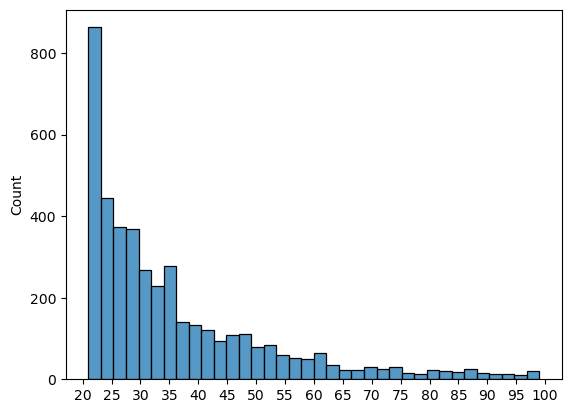

In [9]:
fig, ax = plt.subplots()
sns.histplot(
    np.array(df[(df["tries_count"] > 20) & (df["tries_count"] < 100)]["tries_count"]),
    ax=ax,
)
ax.set_xticks(range(20, 101, 5));

Если на задачу совершено более 65 попыток, будем считать это выбросом - в распределении на этом месте есть явный спад, и кличество совершающих более 65 попыток для каждого бина примерно одинаково мало.

In [10]:
TRIES_COUNT_OUTLIER = 65
df_filtered = df[df["tries_count"] <= 65]

In [11]:
median_tries_with_zeros = df.groupby(by="course_element_id")["tries_count"].median()
mean_tries_with_zeros = df_filtered.groupby(by="course_element_id")[
    "tries_count"
].mean()
df_no_zeros = df[df["tries_count"] > 0]
df_no_zeros_filtered = df_filtered[df_filtered["tries_count"] > 0]
median_tries_no_zeros = df_no_zeros.groupby(by="course_element_id")[
    "tries_count"
].median()
mean_tries_no_zeros = df_no_zeros_filtered.groupby(by="course_element_id")[
    "tries_count"
].mean()

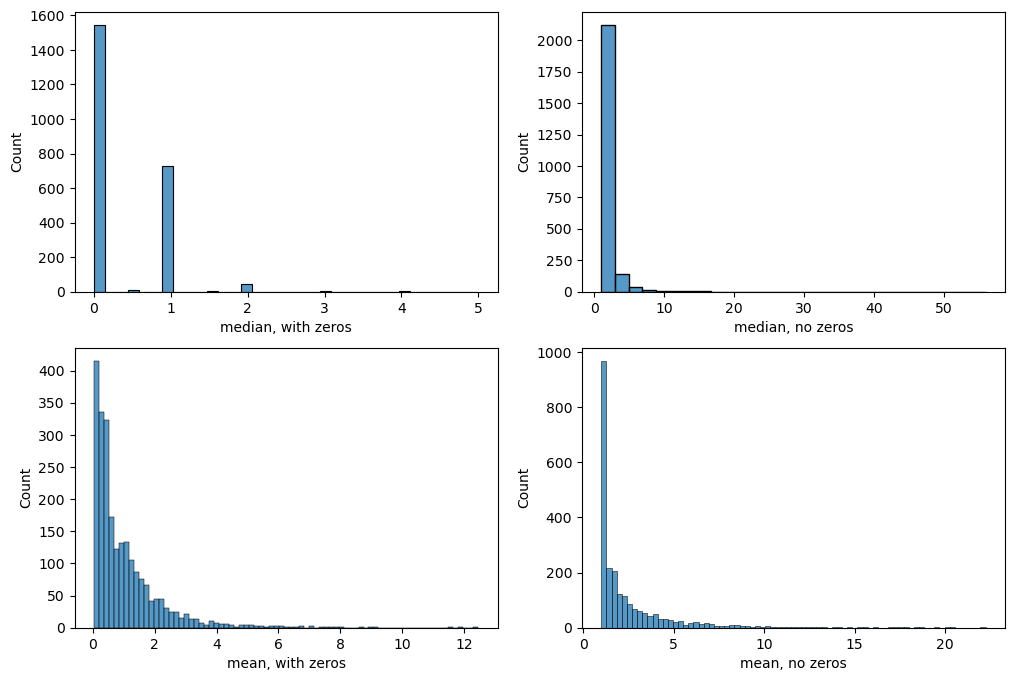

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(median_tries_with_zeros, ax=ax[0][0])
ax[0][0].set(xlabel="median, with zeros")
sns.histplot(median_tries_no_zeros, ax=ax[0][1], binwidth=2)
ax[0][1].set(xlabel="median, no zeros")
sns.histplot(mean_tries_with_zeros, ax=ax[1][0])
ax[1][0].set(xlabel="mean, with zeros")
sns.histplot(mean_tries_no_zeros, ax=ax[1][1])
ax[1][1].set(xlabel="mean, no zeros");

Во-первых, давайте рассматривать средние, а не медианы - на средних более заметны значимые спады между промежуточными значениями, которые потенциально могут стать критическими значениями.

Во-вторых, распределения с учетом и без учета нулей очень похожи по спадам и подъемам - распределение с нулями лишь немного смещено влево. Поэтому, вероятно, нет большой разницы, какое из них взять. Возьмем с нулями, чтобы не усложнять восприятие метрики. Идея другого решения: взять только ненулевое количество попыток, но добавить % нерешавших задачу из тех, кому она открыта, в качестве отдельной метрики.


Замечание: мы выкинули из рассмотрения тех, у кого >65 попыток, но может стоило заменить их на 65, чтобы все равно учитывать, что пользователь сделал много попыток?

Подумаем теперь, что можно считать критическим значением этой метрики.

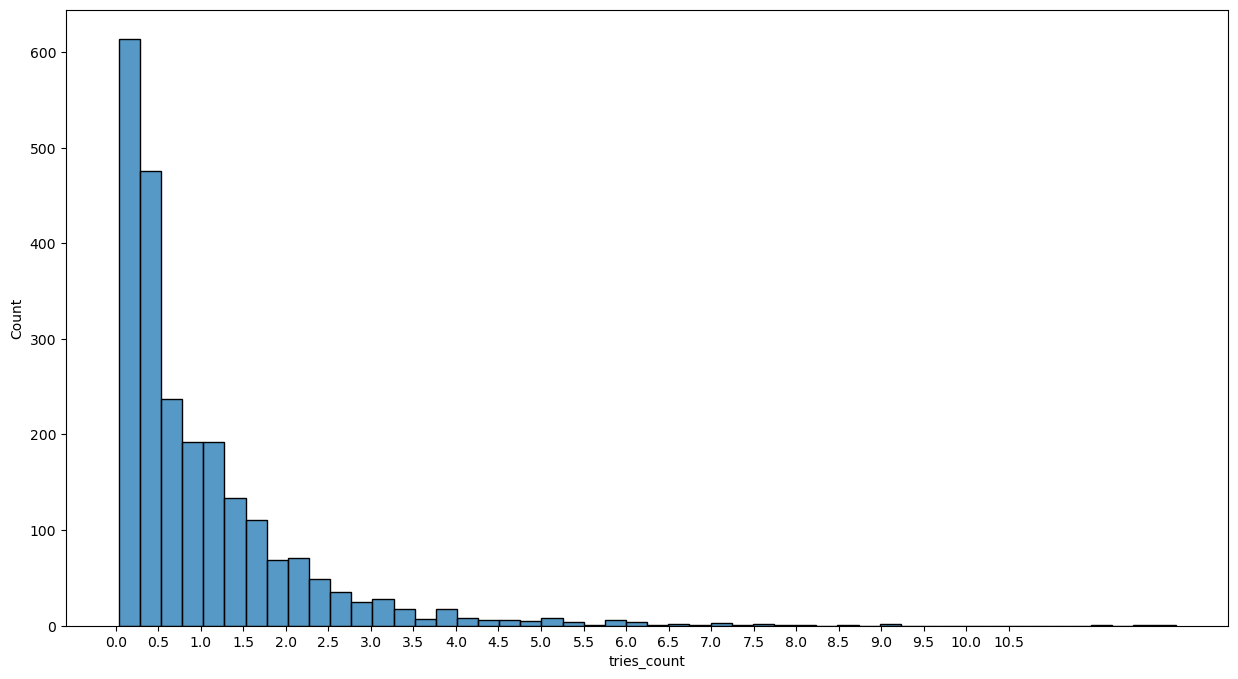

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(mean_tries_with_zeros, ax=ax, binwidth=0.25)
ax.set_xticks(np.arange(0, 11, 0.5));

Будем считать сложными задачи, на которые в среднем сделано более 4 попыток.

In [12]:
mean_tries_threshold = 4

difficult_percentage = np.count_nonzero(
    mean_tries_no_zeros > mean_tries_threshold
) / len(mean_tries_no_zeros)
print("{:.2f}".format(difficult_percentage * 100), "% задач мы считаем сложными")

15.90 % задач мы считаем сложными


### tries_std

`df_filtered` - информация о прогрессе учеников по задачам (без учета учеников с перенесенным прогрессом), выкинуты выбросы по `tries_count`.

In [14]:
tries_std = (
    df_filtered[["course_element_id", "tries_count"]]
    .groupby("course_element_id")
    .std()["tries_count"]
)
tries_std = np.array(tries_std)

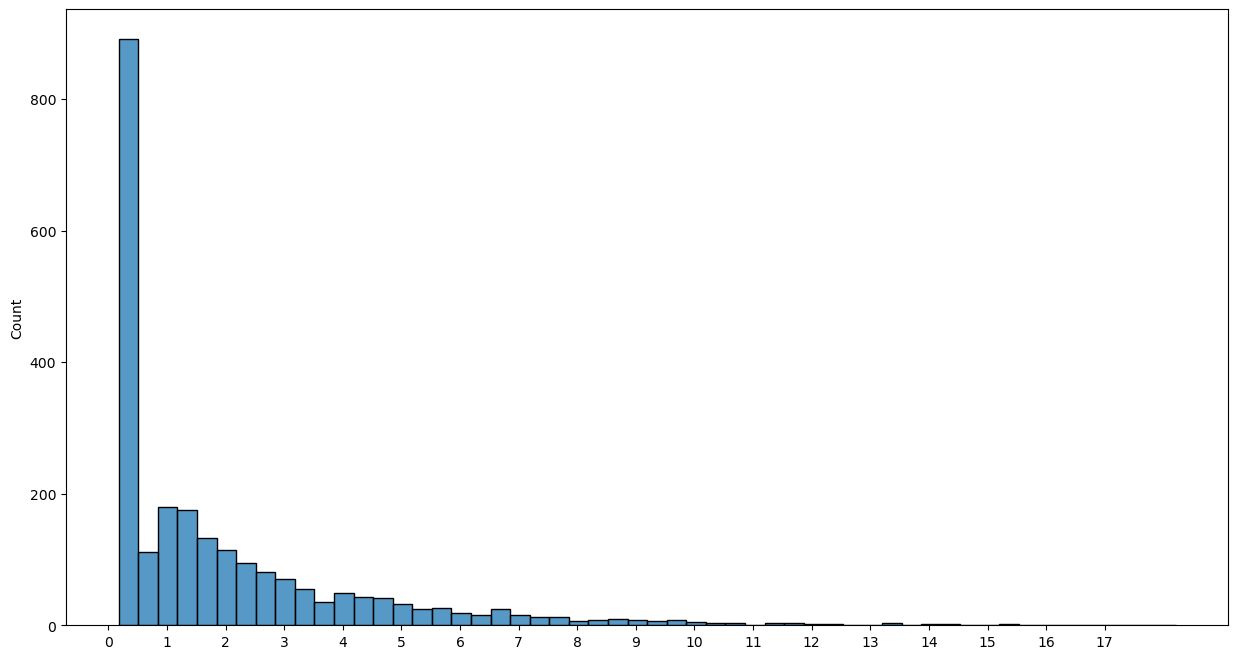

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(tries_std, ax=ax)
ax.set_xticks(np.arange(0, 18, 1));

In [16]:
tries_std_threshold = 5

difficult_percentage = np.count_nonzero(tries_std > tries_std_threshold) / len(
    tries_std
)
print("{:.2f}".format(difficult_percentage * 100), "% задач мы считаем сложными")

10.64 % задач мы считаем сложными


### skips_percentage

Доля пользователей, пропустивших задачу, среди тех, кому открыта задача.

Пропуск задачи - это когда пользователь решил задачу, которая позже в модуле по порядку, раньше, чем данную (или вовсе не решил данную).

`df` - информация о прогрессе учеников по задачам (без учета учеников с перенесенным прогрессом).

In [17]:
columns_for_skips = [
    "user_id",
    "course_element_id",
    "course_module_id",
    "position",
    "time_achieved",
]

course_element = course_element.rename(
    columns={
        "module_id": "course_module_id",
        "element_id": "course_element_id",
        "element_type": "course_element_type",
    }
)
df_for_skips = pd.merge(
    df,
    course_element,
    how="inner",
    on=["course_module_id", "course_element_type", "course_element_id"],
)[columns_for_skips]

In [19]:
def add_skipped_column(group):
    group = group.sort_values(by="position")  # для корректности на NaN
    group = group.sort_values(by="time_achieved")
    group["shift_position"] = group["position"].shift()
    group["max_solved_before"] = group["shift_position"].rolling(2, min_periods=1).max()
    # номер задачи меньше максимального номера уже решенной задачи => ее пропускали
    group["skipped"] = group["position"].le(group["max_solved_before"])
    # group['skipped'] = group['position'].le(group['position'].shift().rolling(2, min_periods=1).max())
    return group

#### Примеры работы функции

In [20]:
group = df_for_skips[df_for_skips["user_id"] == 100120070111137071]
group = group[group["course_module_id"] == 5163]
add_skipped_column(group)

,user_id,course_element_id,course_module_id,position,time_achieved,shift_position,max_solved_before,skipped
1032920,100120070111137071,5823,5163,3,2021-11-12 16:05:40.963136,NaN,NaN,False
1029670,100120070111137071,5825,5163,6,2021-11-12 16:13:44.376214,3.0,3.0,False
1028066,100120070111137071,5826,5163,7,2021-11-12 16:15:24.177609,6.0,6.0,False
1026662,100120070111137071,5827,5163,8,2021-11-12 16:15:43.363909,7.0,7.0,False
1025302,100120070111137071,5828,5163,9,2021-11-12 16:17:38.258382,8.0,8.0,False
1022482,100120070111137071,6040,5163,11,2021-11-12 16:33:57.316330,9.0,9.0,False
1020999,100120070111137071,5829,5163,12,2021-11-12 16:35:28.185631,11.0,11.0,False
891400,100120070111137071,6038,5163,13,2021-11-12 16:41:28.025386,12.0,12.0,False
1031292,100120070111137071,8673,5163,4,NaN,13.0,13.0,True
1023908,100120070111137071,6039,5163,10,NaN,4.0,13.0,True


В данном случае пользователь пропустил задачи на позициях 4, 10 - они не решены.

In [21]:
group = df_for_skips[df_for_skips["user_id"] == 100120040111093529]
group = group[group["course_module_id"] == 5528]
add_skipped_column(group)[:5]

,user_id,course_element_id,course_module_id,position,time_achieved,shift_position,max_solved_before,skipped
491652,100120040111093529,15850,5528,2,NaN,NaN,NaN,False
490635,100120040111093529,15852,5528,4,NaN,2.0,2.0,False
471209,100120040111093529,15853,5528,6,NaN,4.0,4.0,False
475365,100120040111093529,15854,5528,7,NaN,6.0,6.0,False
474347,100120040111093529,15855,5528,8,NaN,7.0,7.0,False


В данном случае никакие задачи не решены, так что ничего не пропущено.

In [22]:
group = df_for_skips[df_for_skips["user_id"] == 100120070111137071]
group = group[group["course_module_id"] == 5157]
add_skipped_column(group)[:7]

,user_id,course_element_id,course_module_id,position,time_achieved,shift_position,max_solved_before,skipped
1121231,100120070111137071,9597,5157,3,2021-11-01 09:35:11.918023,NaN,NaN,False
1364510,100120070111137071,5872,5157,5,2021-11-01 09:36:15.877095,3.0,3.0,False
1112319,100120070111137071,8662,5157,7,2021-11-01 09:40:19.911175,5.0,5.0,False
1116586,100120070111137071,13357,5157,6,2021-11-01 09:41:57.313721,7.0,7.0,True
1343762,100120070111137071,5873,5157,8,2021-11-01 09:42:21.708213,6.0,7.0,False
1339840,100120070111137071,5874,5157,9,2021-11-01 09:42:44.960186,8.0,8.0,False
1360409,100120070111137071,5875,5157,10,2021-11-01 09:43:04.289014,9.0,9.0,False


В данном случае задача 6 решена после задачи 7, поэтому она помечена как пропущенная.

#### Подсчет метрики

In [23]:
groups_with_skipped_col = []
columns = ["user_id", "course_element_id", "skipped"]

for groupname, group in df_for_skips.groupby(["user_id", "course_module_id"]):
    group = add_skipped_column(group)[columns]
    groups_with_skipped_col.append(group)

skips_data = pd.concat(groups_with_skipped_col)

In [24]:
skips_data

,user_id,course_element_id,skipped
522204,100119700110000266,764,False
518142,100119700110000266,14175,False
514073,100119700110000266,14605,False
510004,100119700110000266,14606,False
586928,100119700110000266,14607,False
...,...,...,...
130947,100120190110714343,6687,False
130589,100120190110714343,6688,False
130232,100120190110714343,8051,False
129875,100120190110714343,6690,False


In [25]:
skips_count = skips_data.groupby(by="course_element_id").sum()["skipped"]
# согласно документации, запись о пользователе-элементе в user_element_progress есть только тогда, когда задача открыта пользователю
user_count = skips_data.groupby(by="course_element_id").count()["user_id"]

In [26]:
skips_percentage = skips_count / user_count

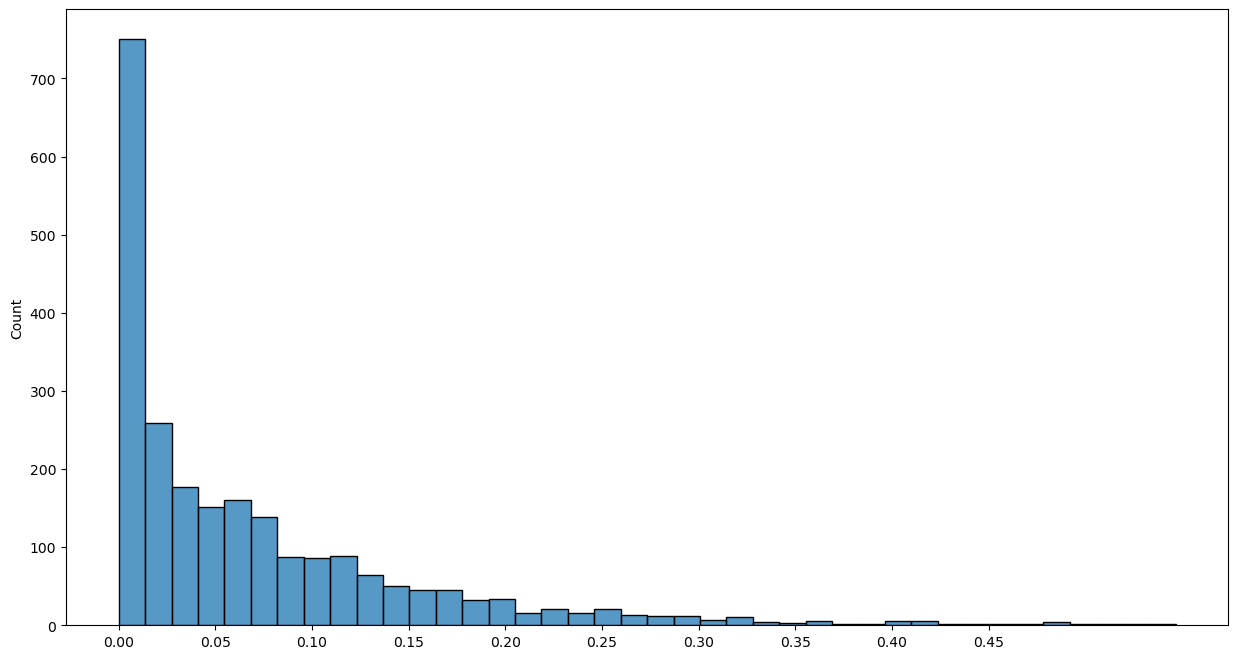

In [27]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(skips_percentage, ax=ax)
ax.set_xticks(np.arange(0, 0.5, 0.05));

В качестве критического значения можно взять 0.2

In [28]:
skips_percentage_threshold = 0.2

difficult_percentage = np.count_nonzero(
    skips_percentage > skips_percentage_threshold
) / len(skips_percentage)
print("{:.2f}".format(difficult_percentage * 100), "% задач мы считаем сложными")

7.82 % задач мы считаем сложными


### lost_percentage

Доля пользователей, не решивших данную задачу среди решивших предыдущую.

Рассматриваются только задачи, идущие после других задач (а не видео/текста).

In [29]:
df_for_lost = pd.merge(
    user_element_progress,
    course_element,
    how="inner",
    on=["course_module_id", "course_element_type", "course_element_id"],
)

In [30]:
columns = [
    "user_id",
    "course_module_id",
    "course_element_type",
    "course_element_id",
    "position",
    "is_achieved",
]

In [31]:
df_for_lost = df_for_lost[columns]

In [33]:
groups = []

for groupname, group in df_for_lost.groupby(["user_id", "course_module_id"]):
    group = group.sort_values("position")
    group["prev_is_task"] = "task" == group["course_element_type"].shift()
    group["prev_is_solved"] = group["is_achieved"].shift()
    # оставим только информацию о задачах
    group = group[group["course_element_type"] == "task"]
    # оставим только задачи, идущие в модуле сразу после других задач (а не видео/текста)
    group = group[group["prev_is_task"]]
    groups.append(group)

In [34]:
lost_data = pd.concat(groups)
lost_data

,user_id,course_module_id,course_element_type,course_element_id,position,is_achieved,prev_is_task,prev_is_solved
807155,100119700110000266,5523,task,14175,3,NaN,True,NaN
799005,100119700110000266,5523,task,14605,4,NaN,True,NaN
880505,100119700110000266,5523,task,14607,7,NaN,True,NaN
876430,100119700110000266,5523,task,14608,8,NaN,True,NaN
872355,100119700110000266,5523,task,14183,9,NaN,True,NaN
...,...,...,...,...,...,...,...,...
200260,100120190110714343,4799,task,6687,28,NaN,True,NaN
199782,100120190110714343,4799,task,6688,29,NaN,True,NaN
199304,100120190110714343,4799,task,8051,30,NaN,True,NaN
198826,100120190110714343,4799,task,6690,31,NaN,True,NaN


In [35]:
lost_data["is_achieved"] = lost_data["is_achieved"].fillna(False)

In [36]:
lost_data["is_lost"] = lost_data["prev_is_solved"] & (~lost_data["is_achieved"])

In [37]:
counts_df = (
    lost_data[["course_element_id", "prev_is_solved", "is_lost"]]
    .groupby("course_element_id")
    .sum()
)
lost_count = counts_df["is_lost"]
solved_prev_count = counts_df["prev_is_solved"]

In [38]:
lost_percentage = lost_count / solved_prev_count

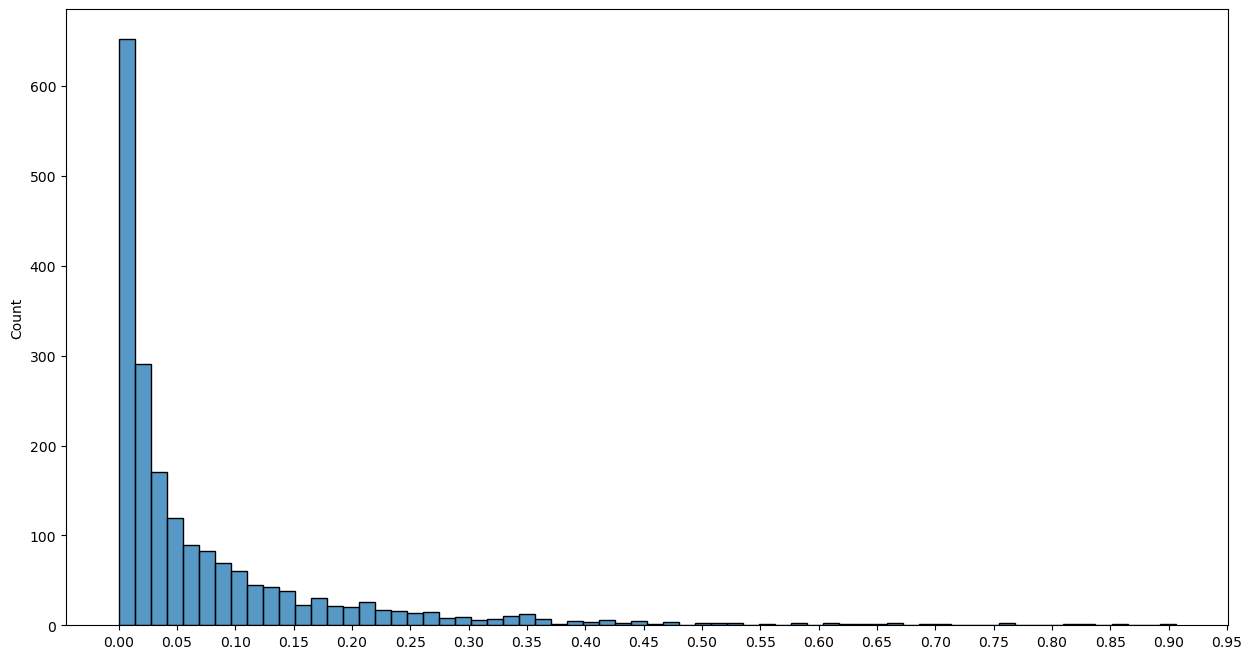

In [39]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(lost_percentage, ax=ax)
ax.set_xticks(np.arange(0, 1, 0.05));

Возьмем критическое значение 0.15

In [40]:
lost_percentage_threshold = 0.15

difficult_percentage = np.count_nonzero(
    lost_percentage > lost_percentage_threshold
) / len(lost_percentage)
print("{:.2f}".format(difficult_percentage * 100), "% задач мы считаем сложными")

15.26 % задач мы считаем сложными


### guessed_percentage

Доля начавших угадывать решение среди пользователей, делавших попытки на задачу

Начал угадывать - если время между попытками < Eps в течение N попыток

`df` - информация о прогрессе учеников по задачам (без учета учеников с перенесенным прогрессом).

In [115]:
df_tried = df[df["tries_count"] > 0]

In [116]:
solution_log["submission_time"] = pd.to_datetime(solution_log["submission_time"])
element_progress_ids = solution_log["element_progress_id"].unique()
# по element_progress_id записано, угадывалась ли данная задача данным пользователем
progress_id_guessed = pd.Series(
    data=[False] * len(element_progress_ids), index=element_progress_ids
)

Пользователь начал угадывать = сделано хотя бы `N` попыток, где разница между соседними попытками `<= max_time_delta`

In [117]:
from tqdm import tqdm

max_time_delta = pd.Timedelta(seconds=10)
N = 3

for group_id, group in tqdm(solution_log.groupby("element_progress_id")):
    if len(group) < N:
        # если N попыток не сделано, то "угадывания" точно не было
        progress_id_guessed[group_id] = False
        continue
    group = group.sort_values("submission_time")
    # group['prev_time'] = group['submission_time'].shift()
    # group['time_delta'] = group['submission_time'] - group['submission_time'].shift()
    group["is_guess"] = (
        group["submission_time"] - group["submission_time"].shift()
    ) <= max_time_delta
    group["is_N_guesses"] = group["is_guess"].rolling(N, min_periods=1).min()
    progress_id_guessed[group_id] = group["is_N_guesses"].any()

100%|██████████████████████████████| 1091523/1091523 [01:43<00:00, 10503.55it/s]


In [118]:
guess_data = pd.DataFrame(
    {"id": progress_id_guessed.index, "guessed": progress_id_guessed.values}
)

In [119]:
df_tried = pd.merge(df_tried, guess_data, how="left", on="id")
guessed_count = (
    df_tried[["course_element_id", "guessed"]]
    .groupby("course_element_id")
    .sum()["guessed"]
)

In [120]:
# количество пытавшихся решить задачу
tried_count = (
    df_tried[["course_element_id", "tries_count"]]
    .groupby("course_element_id")
    .count()["tries_count"]
)

In [121]:
guessed_percentage = guessed_count / tried_count

<Axes: ylabel='Count'>

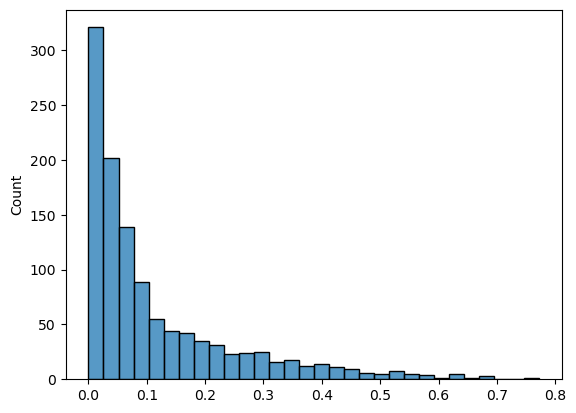

In [122]:
# на графике распределение ненулевых значений
sns.histplot(guessed_percentage[guessed_percentage > 0])

In [123]:
print(f"Количество нулей: {len(guessed_percentage[guessed_percentage == 0])}")

guessed_percentage_threshold = 0.2

difficult_percentage = np.count_nonzero(
    guessed_percentage > guessed_percentage_threshold
) / len(guessed_percentage)
print("{:.2f}".format(difficult_percentage * 100), "% задач мы считаем сложными")

Количество нулей: 1191
9.74 % задач мы считаем сложными


### solved_percentage

In [33]:
df = user_element_progress[user_element_progress["course_element_type"] == "task"]
df = df[df["achieve_reason"] != "transferred"]

In [34]:
df = df[df["tries_count"] > 0]
df["is_achieved"] = df["is_achieved"].fillna(False).astype(int)
grouped = (
    df[["course_element_id", "is_achieved", "user_id"]]
    .groupby("course_element_id")
    .agg({"user_id": "count", "is_achieved": "sum"})
    .reset_index()
)
solved_percentage = pd.DataFrame(
    {
        "element_id": grouped["course_element_id"],
        "solved_percentage": grouped["is_achieved"] / grouped["user_id"],
    }
)

In [35]:
solved_percentage

,element_id,solved_percentage
0,293,0.986842
1,298,0.984615
2,299,1.000000
3,300,1.000000
4,301,1.000000
...,...,...
2335,16084,0.909091
2336,16085,1.000000
2337,16086,1.000000
2338,16088,1.000000


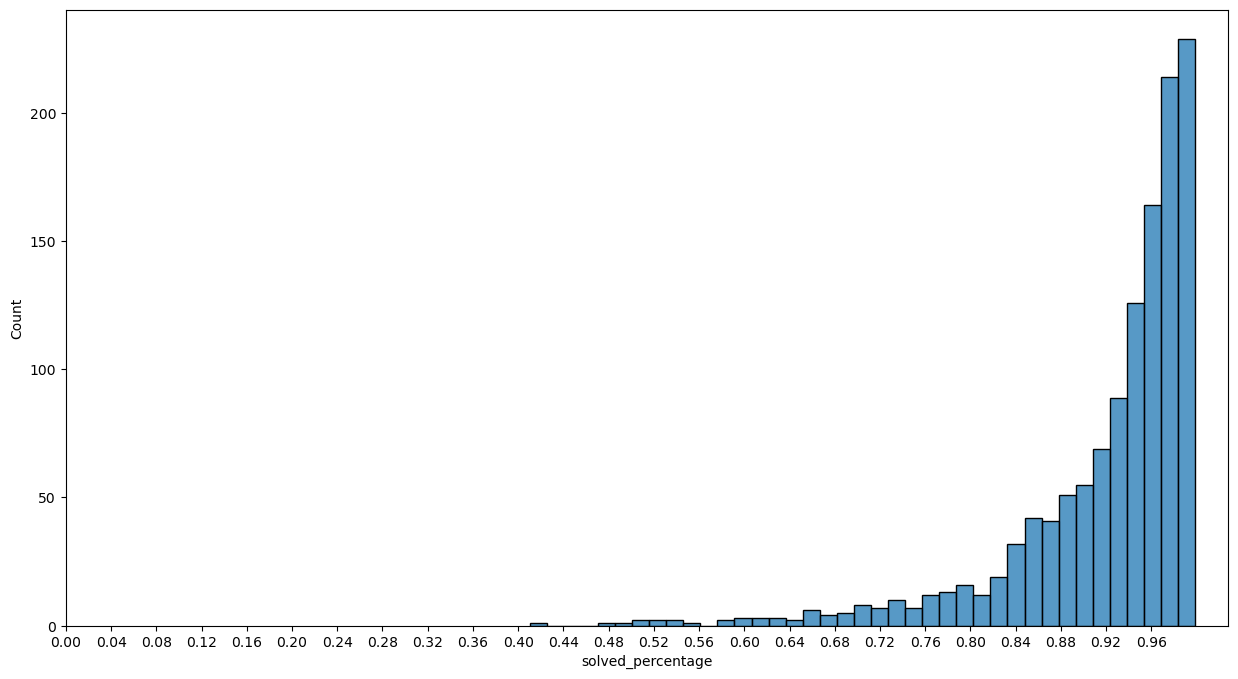

In [50]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(
    solved_percentage[solved_percentage["solved_percentage"] < 1]["solved_percentage"],
    ax=ax,
)
ax.set_xticks(np.arange(0, 1, 0.04));

In [37]:
all_solved_count = len(solved_percentage[solved_percentage["solved_percentage"] == 1])
print(f"Есть {all_solved_count} задач, которые решили все попытавшиеся")

Есть 1086 задач, которые решили все попытавшиеся


In [51]:
solved_percentage_threshold = 0.88

difficult_percentage = np.count_nonzero(
    solved_percentage["solved_percentage"] < solved_percentage_threshold
) / len(solved_percentage)
print("{:.2f}".format(difficult_percentage * 100), "% задач мы считаем сложными")

11.15 % задач мы считаем сложными


### user count

In [14]:
df = user_element_progress[user_element_progress["course_element_type"] == "task"]
df = df[df["achieve_reason"] != "transferred"]
tried_progress = df[df['tries_count'] > 0]
user_count = tried_progress.groupby('course_element_id').agg({'user_id': 'count'}).reset_index().rename(columns={'course_element_id': 'element_id', 'user_id': 'user_count'})

<Axes: xlabel='user_count', ylabel='Count'>

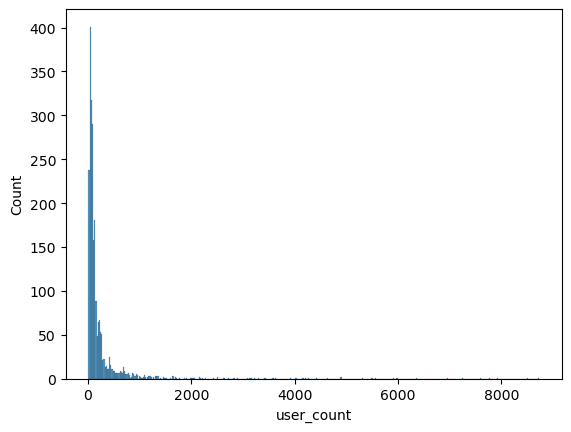

In [15]:
sns.histplot(user_count['user_count'])

<Axes: xlabel='user_count', ylabel='Count'>

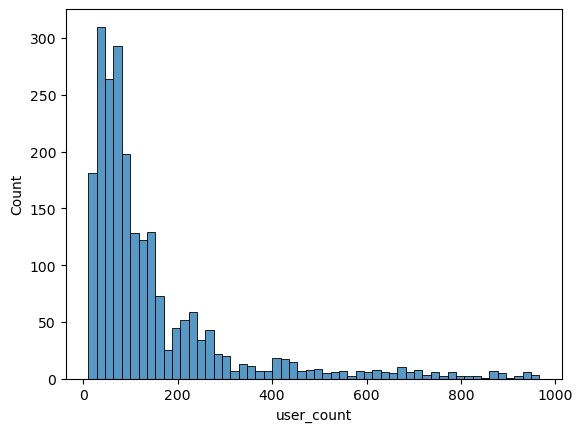

In [19]:
sns.histplot(user_count[user_count['user_count'] < 1000]['user_count'])

In [54]:
df = user_count.merge(course_element, how='left', on='element_id')[['element_id', 'module_id', 'position', 'user_count', 'is_advanced']]
df = df[~df['is_advanced']]
df = df.merge(course_module[['course_id', 'id']].rename(columns={'id':'module_id'}), on='module_id')

In [56]:
groups = []

for groupname, group in df.groupby(['course_id', 'module_id']):
    group = group.sort_values("position")
    group["diff"] = group['user_count'] - group["user_count"].shift()
    groups.append(group)

df = pd.concat(groups)

In [61]:
df['diff'] = df['diff'].fillna(0)
df['diff_prct'] = df['diff']/df['user_count']*100
df

,element_id,module_id,position,user_count,is_advanced,course_id,diff,diff_prct
826,5965,4792,2,103,False,560,0.0,0.000000
845,8343,4792,4,109,False,560,6.0,5.504587
846,10856,4792,6,94,False,560,-15.0,-15.957447
827,5972,4792,9,98,False,560,4.0,4.081633
847,10935,4792,11,106,False,560,8.0,7.547170
...,...,...,...,...,...,...,...,...
937,4353,5549,11,19,False,638,0.0,0.000000
939,4355,5549,12,18,False,638,-1.0,-5.555556
936,4352,5549,13,17,False,638,-1.0,-5.882353
932,4301,5549,17,19,False,638,2.0,10.526316


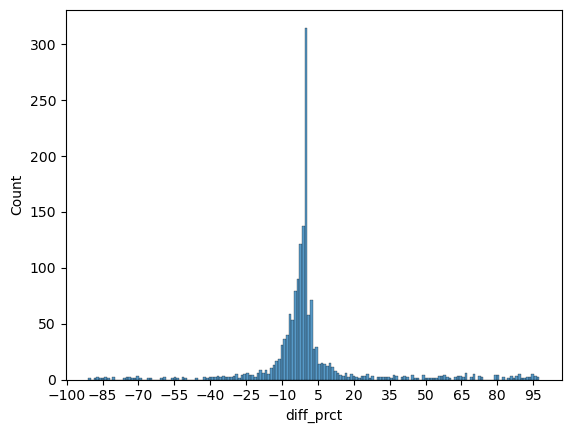

In [66]:
sns.histplot(df[df['diff_prct'] > -100]['diff_prct'])
plt.xticks(np.arange(-100, 100, 15));

In [68]:
diff_prct_threshold = -15

difficult_percentage = np.count_nonzero(df['diff_prct'] < diff_prct_threshold) / len(
    df
)
print("{:.2f}".format(difficult_percentage * 100), "% задач мы считаем сложными")

12.37 % задач мы считаем сложными
